In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import theano.tensor as tt
import warnings

from scipy import stats
from scipy.special import expit as logistic
from scipy.special import softmax

%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 89954
np.random.seed(254386)

In [2]:
az.style.use("arviz-darkgrid")
az.rcParams["stats.credible_interval"] = 0.89

#### Code 15.29

In [3]:
N_houses = 100
alpha = 5 # avg nb of notes in houses
beta = -3 # slope for cat influence
true_k = 0.3 # probability of having a cat
r = 0.2 # probability that we don't know if a house has a cat

In [4]:
cat = stats.bernoulli.rvs(true_k, size=N_houses)
cat_obs = np.copy(cat)
notes = stats.poisson.rvs(alpha + beta * cat_obs, size=N_houses)

R_C = stats.bernoulli.rvs(r, size=N_houses) # house with known and unknown cats

cat_obs[R_C == 1] = -9 # arbitrary impossible replacement to signal a misssing value

#### Code 15.30

In [5]:
with pm.Model() as m15_8:
    # sneaking cat model
    k = pm.Beta("k", 2., 2.)
    cat_known = pm.Bernoulli("cat|RC==0", k, observed=cat_obs[cat_obs != -9])
    
    # singing bird model
    ## priors:
    a = pm.Normal("a", 0, 1.)
    b = pm.Normal("b", 0, 0.5)
    ## cat NA:
    
    #### RL's comment: I still unsure about this part below. Here I have the impression that you are doing log(a + b) = log(a) + log(b)
    
    custom_like = pm.math.log(k) + pm.Poisson.dist(pm.math.exp(a + b)).logp(notes[cat_obs == -9]) + pm.math.log(1 - k) + pm.Poisson.dist(pm.math.exp(a)).logp(notes[cat_obs == -9])
    notes_cat_unknown = pm.Deterministic("notes|RC==1", pm.math.logsumexp([custom_like], axis=1))
    
    ## cat known present / absent:
    lam = pm.math.exp(a + b * cat_obs[cat_obs != -9])
    notes_cat_known = pm.Poisson("notes|RC==0", lam, observed=notes[cat_obs != -9])
    
    trace_15_8 = pm.sample(2000, random_seed=RANDOM_SEED)
idata_15_8 = az.from_pymc3(trace_15_8)
az.summary(idata_15_8, var_names=["a", "b", "k"], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a, k]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:04<00:00, 1166.71draws/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.63,0.05,1.52,1.72,0.0,0.0,4179.44,4179.44,4190.99,3053.23,1.0
b,-1.10,0.18,-1.46,-0.79,0.0,0.0,4068.13,3915.79,4107.73,2892.20,1.0
k,0.22,0.04,0.13,0.30,0.0,0.0,4186.29,4153.34,4101.70,2465.11,1.0


In [11]:
observed = (cat_obs[cat_obs!=-9].sum()*100 / len(cat_obs[cat_obs!=-9])).round(1)
real = (cat.sum() * 100 / len(cat)).round(3) 

print("we have observed {0} % houses with cat. In reality there are {1} % houses with cats".format(observed,real))
print("we have predicted {0} % houses with cat. The interval is {1}".format(trace_15_8["k"].mean().round(3)*100,pm.hpd(trace_15_8["k"],0.89).round(3) * 100 ))

we have observed 20.2 % houses with cat. In reality there are 27.0 % houses with cats
we have predicted 21.5 % houses with cat. The interval is [14.6 28.7]


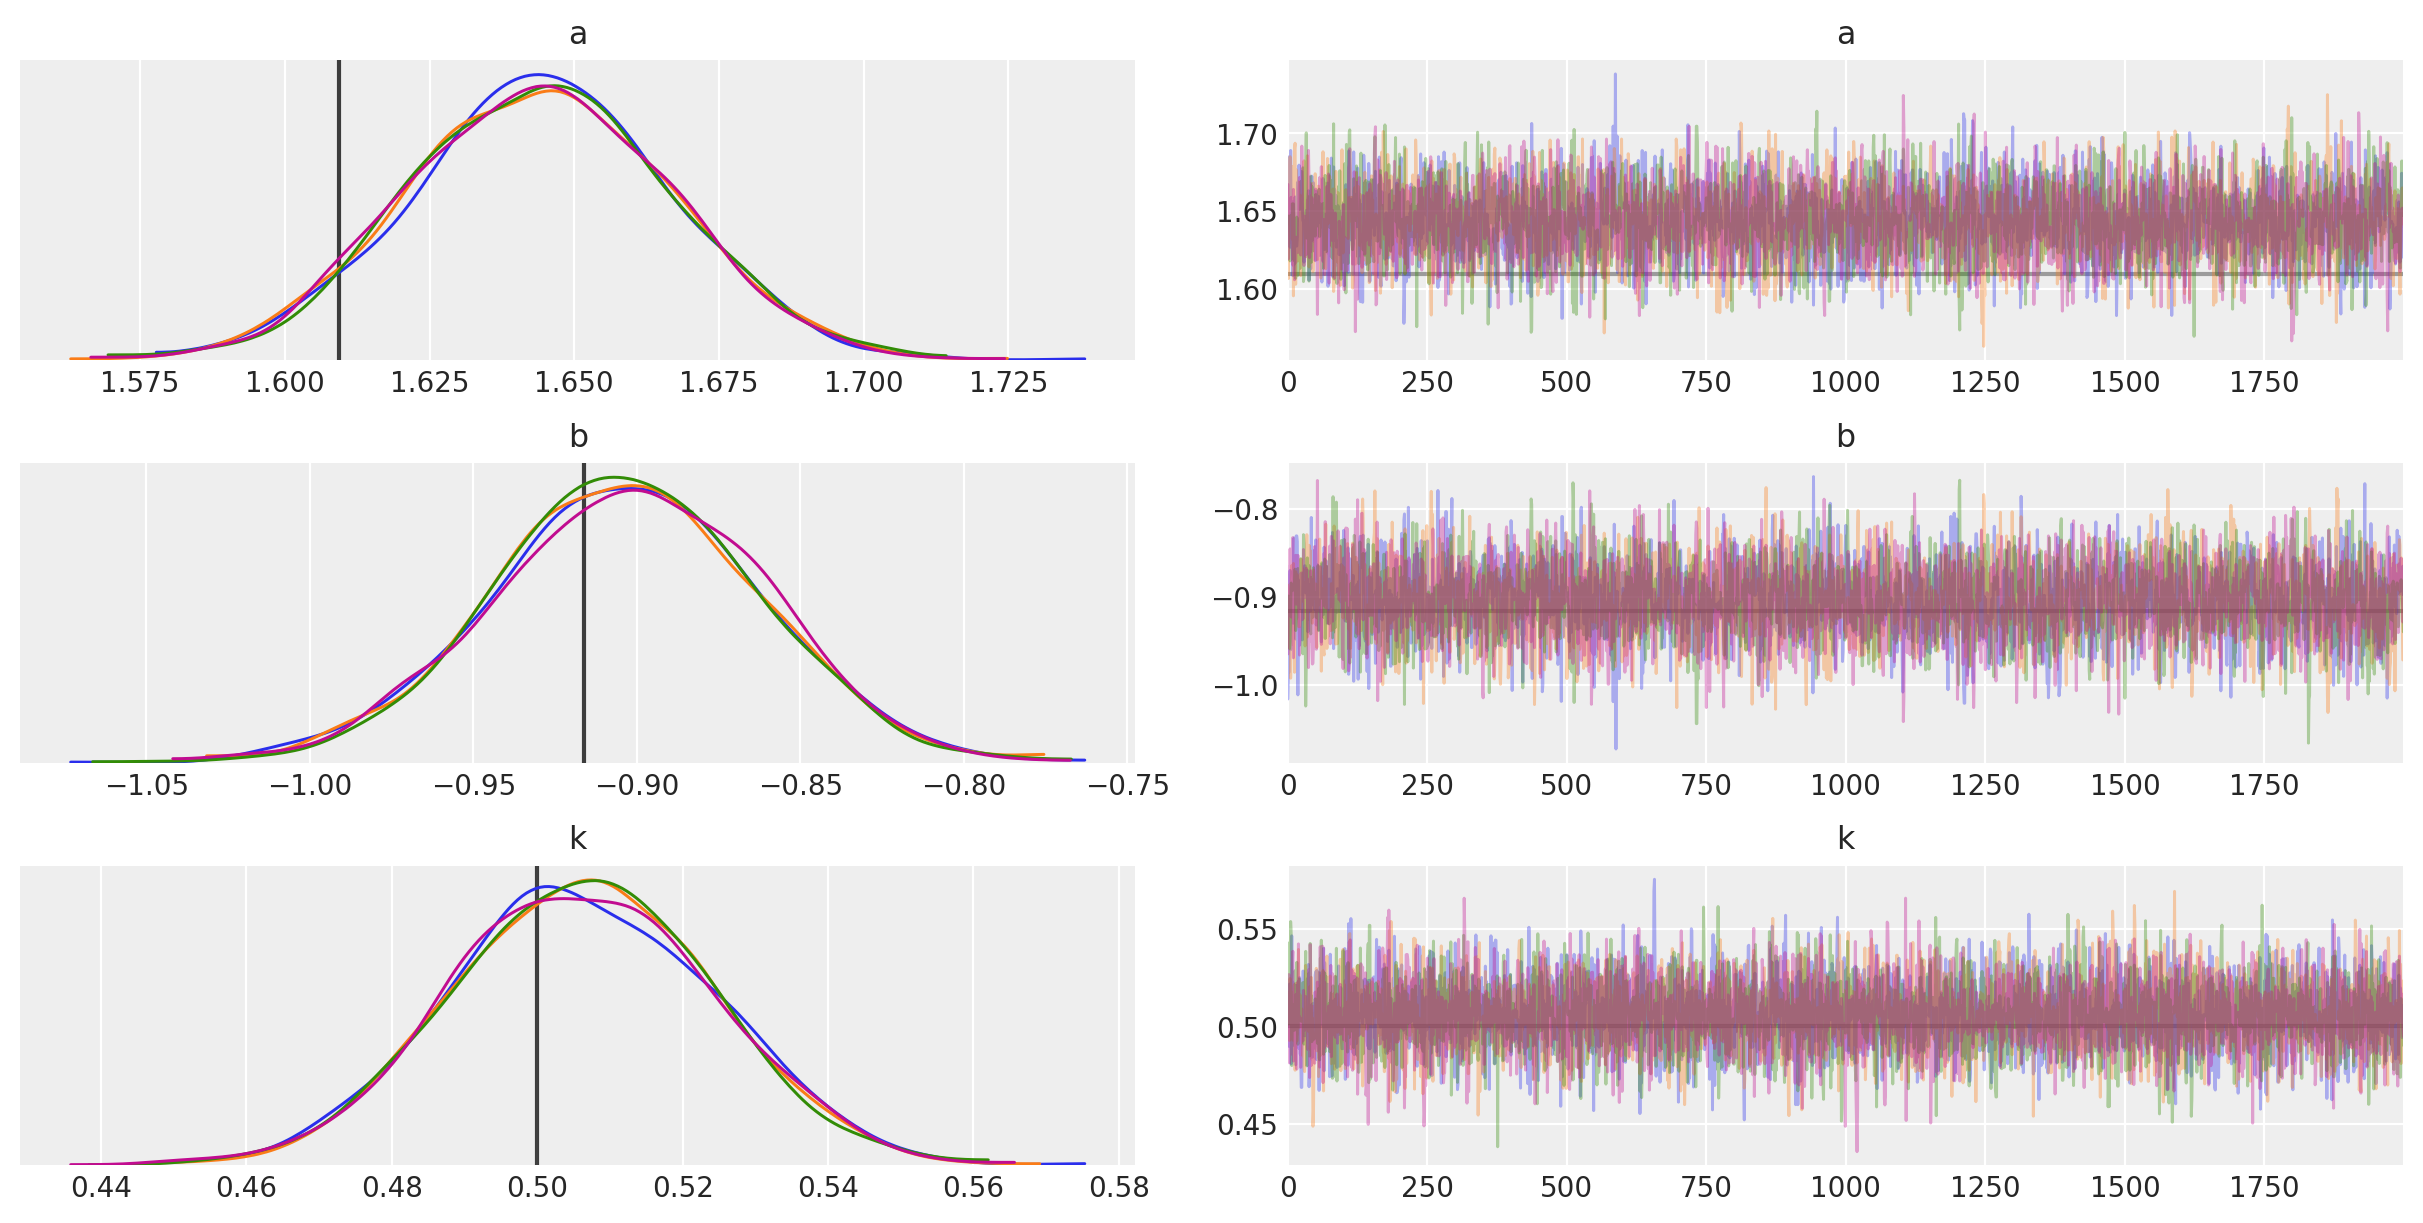

In [7]:
lines = [("a", {}, np.log(alpha)), ("b", {}, np.log((alpha + beta) / alpha)), ("k", {}, true_k)]
az.plot_trace(idata_15_8, var_names=["a", "b", "k"], lines=lines);

#### Code 15.31

In [8]:
cat_obs = stats.bernoulli.rvs(true_k, size=N_houses)
notes = stats.poisson.rvs(alpha + beta * cat_obs, size=N_houses)

R_C = stats.bernoulli.rvs(r, size=N_houses) # house with known and unknown cats

cat_obs[R_C == 1] = -9 # arbitrary impossible replacement to signal a misssing value
cat_obs = np.ma.masked_values(cat_obs, value=-9)

In [9]:
with pm.Model() as m15_9:
    # sneaking cat model
    k = pm.Beta("k", 2., 2.)
    cat = pm.Bernoulli("cat", k, observed=cat_obs)
    
    # singing bird model
    a = pm.Normal("a", 0., 1.0)
    b = pm.Normal("b", 0., 0.5)
    # PyMC3 handles missing values automatically
    lam = pm.math.exp(a + b * cat)
    notes_obs = pm.Poisson("notes", lam, observed=notes)
    
    trace_15_9 = pm.sample(2000, random_seed=RANDOM_SEED)
idata_15_9 = az.from_pymc3(trace_15_9)
az.summary(idata_15_9, var_names=["a", "b", "k"], round_to=2)

/Users/alex_andorra/opt/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/pymc3/model.py:1515: ImputationWarning: Data in cat contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [b, a, k]
>BinaryGibbsMetropolis: [cat_missing]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 51 seconds.


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.59,0.02,1.55,1.62,0.0,0.0,5158.09,5158.09,5159.23,6040.90,1.0
b,-0.87,0.04,-0.94,-0.81,0.0,0.0,4775.04,4775.04,4773.96,5332.61,1.0
k,0.50,0.02,0.48,0.53,0.0,0.0,6714.24,6714.24,6718.47,5512.09,1.0


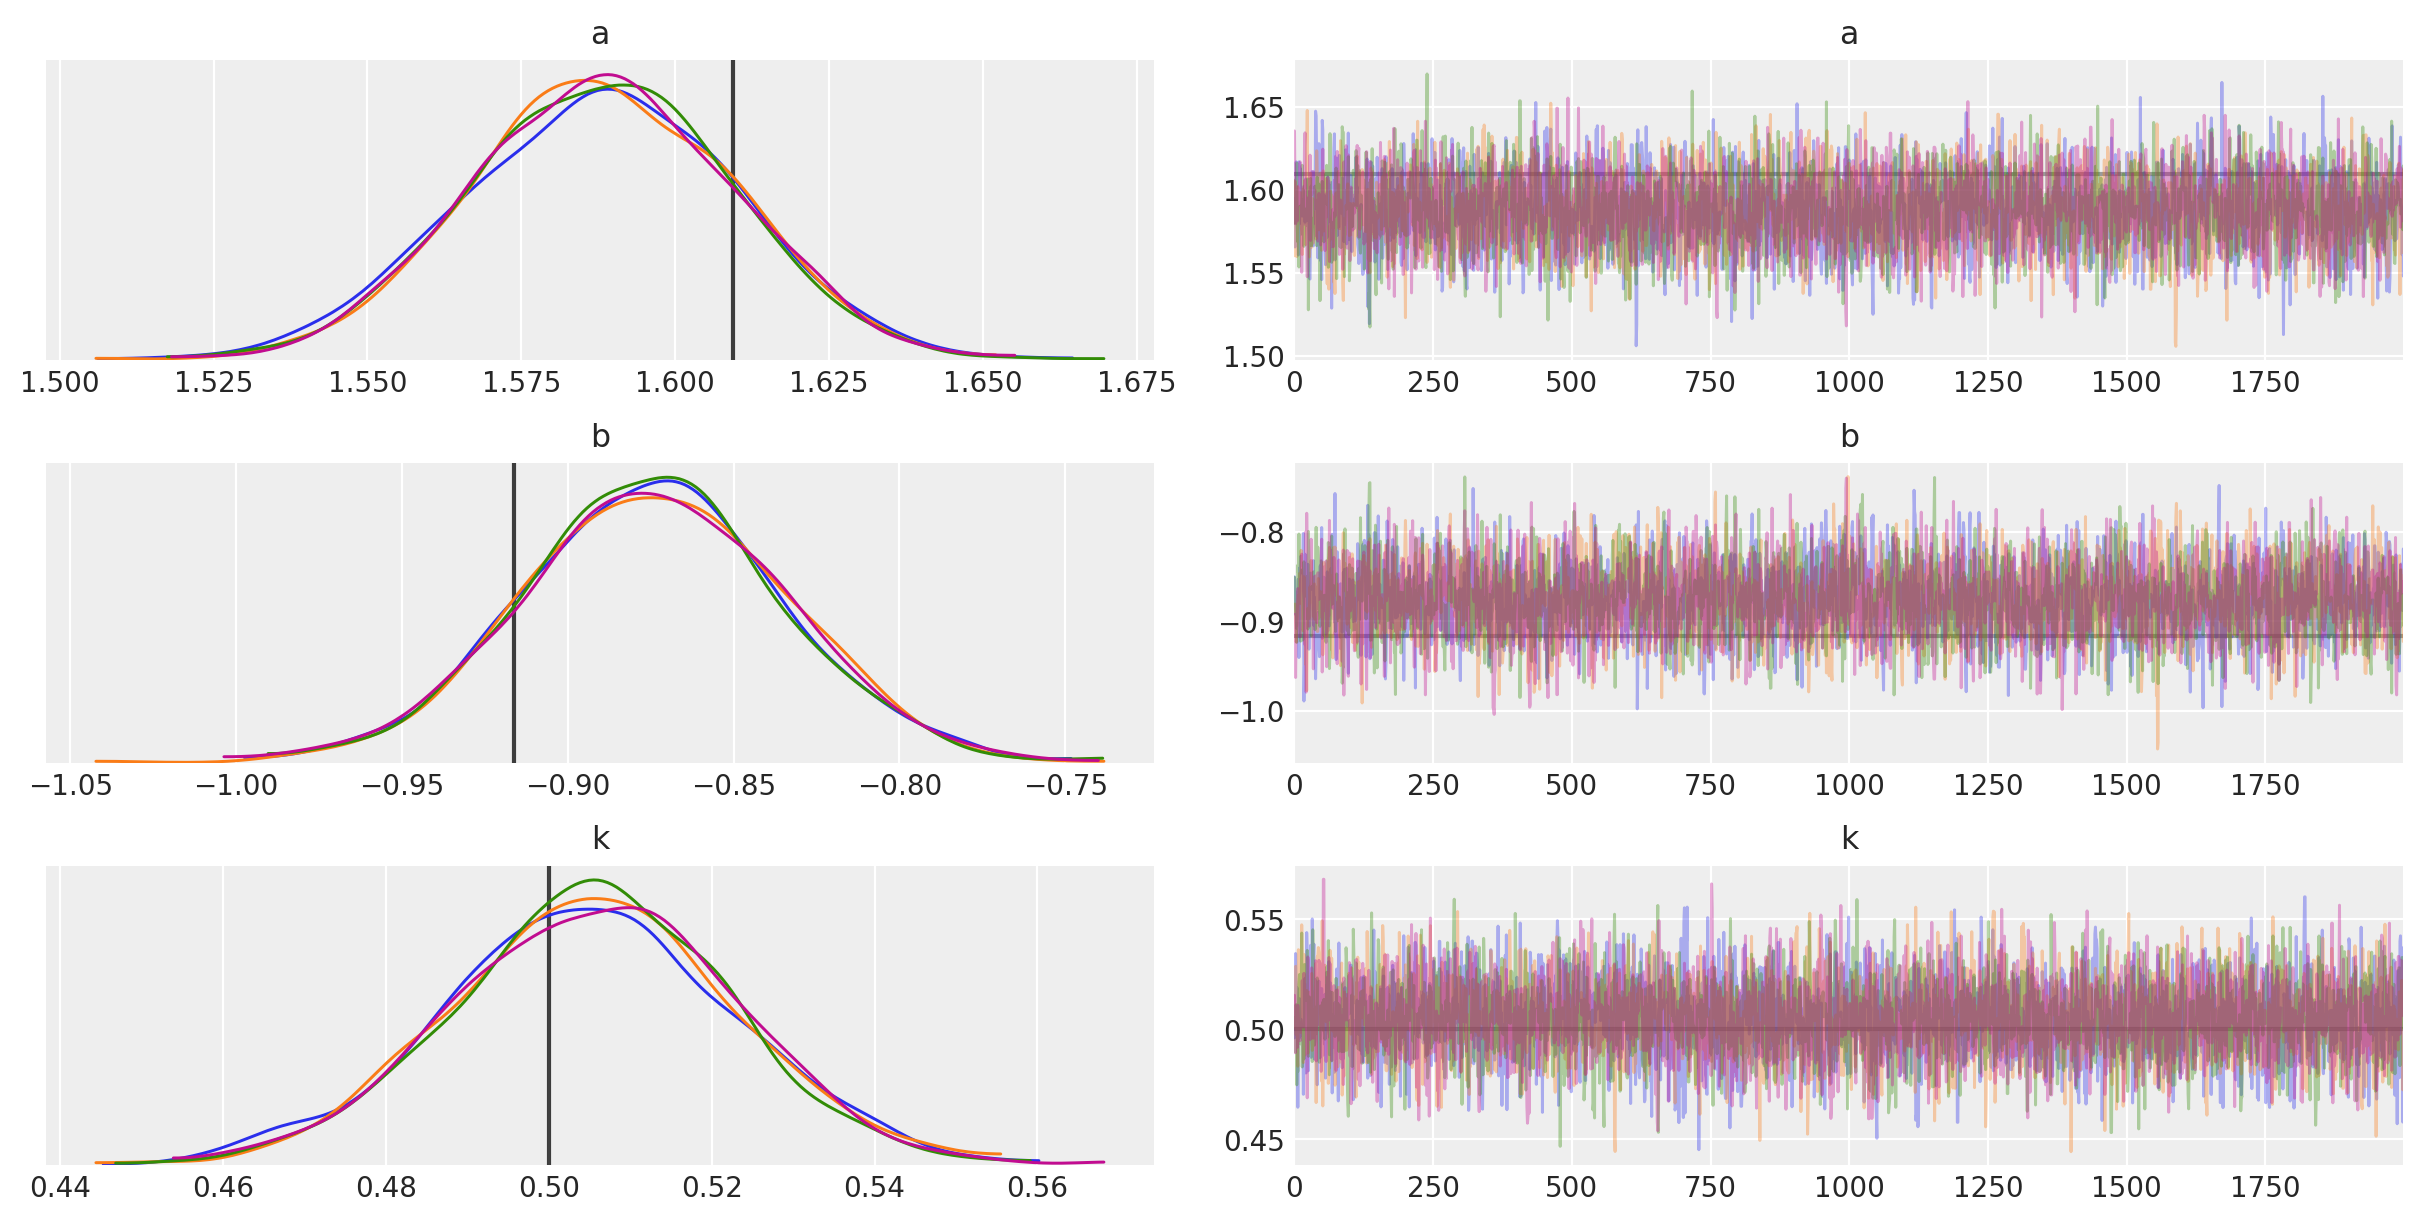

In [10]:
az.plot_trace(idata_15_9, var_names=["a", "b", "k"], lines=lines);